In [1]:
from orphics import sehgal, maps
import healpy as hp
from pixell import utils, enmap, curvedsky, enplot, wcsutils
import os
import numpy as np

import matplotlib.pyplot as plt
import lmdb
from cosmikyu import datasets, transforms, sehgal as csehgal

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
import torch as torch

In [13]:
a = torch.rand(4,4)
print(torch.var(a, dim=[-1,-2]))
print(torch.var(a))


tensor(0.1265)
tensor(0.1265)


In [2]:
compts = ["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]

shape, wcs = enmap.fullsky_geometry(res=0.5*utils.arcmin)
ycent = shape[0] // 2
ydelta = int(10*utils.degree/(0.5*utils.arcmin))
ymin, ymax = ycent-ydelta, ycent+ydelta
print(shape, ycent, ydelta, ymin, ymax)

template = enmap.zeros(shape, wcs)
template = template[ymin:ymax,:].copy()
nshape, nwcs = template.shape, template.wcs
nshape = (len(compts),) + nshape
print(nshape, nwcs)
areamap = enmap.pixsizemap(nshape[-2:], nwcs)
modlmap = template.modlmap()

(21601, 43200) 10800 1200 9600 12000
(5, 2400, 43200) car:{cdelt:[-0.008333,0.008333],crval:[0.004167,0],crpix:[2.16e+04,1201]}


In [3]:
rot_angles1 = [0, 15, 30, 45, 60, 75]
rot_angles2 = [0, 20, 40, 60, 80]

TRAIN_SET = 0
TEST_SET = 1
VALIDATION_SET = 2

input_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues"
CSEHGAL = csehgal.Sehgal10ReprojectedFromCat(input_dir, nshape[-2:], nwcs)

output_dir = "/home/dwhan89/workspace/cosmikyu/data/sehgal"
def output_path(x):
    return os.path.join(output_dir, x)

#test = get_input_map(15,20, nshape, nwcs)


In [4]:

def get_random_seed(euler_angle, set_idx, sim_idx):
    return tuple(euler_angle) + (set_idx, sim_idx)

nset = 25
ntrain = 200*1000
ntest = 30*1000
nvalidation = 30*1000
overwrite = True

stamp_byte = np.zeros((len(compts),128,128), dtype=np.float64).nbytes
def taskrange(nsample, set_idx, size):
   
    ntask = nsample
    subrange = None

    if size > ntask:
        delta     = 1
        remainder = 0
    else:
        delta     = ntask//size
        remainder = ntask%size
 
    start      = set_idx*delta
    scorr      = min(set_idx, remainder)
    start      += scorr

    delta      += 1 if set_idx < remainder else 0


    end        = start + delta
    end        = min(end, ntask)
    subrange   = np.arange(start, end)
    return subrange

def get_next_pixpos(seed, shape,  stamp_width_pix=128):
    np.random.seed(seed)
    yfrom = np.random.randint(0, shape[-2]-stamp_width_pix)
    xfrom = np.random.randint(0, shape[-1]-stamp_width_pix)
    yto = yfrom + stamp_width_pix
    xto = xfrom + stamp_width_pix
    return (yfrom, xfrom, yto, xto)
    
#train_db = output_path("sehgal_train141020")
train_db = output_path("sehgal_train281220_fromcat")
if not os.path.exists(train_db) or overwrite:
    map_size = stamp_byte*ntrain*10
    DB = lmdb.open(train_db, map_size=map_size)
    with DB.begin(write=True) as txn:
        ctr = 0
        for rot_angle1 in rot_angles1:
            for rot_angle2 in rot_angles2:
                if rot_angle1 != 0 and rot_angle2 == 0: continue
                print("set idx", ctr, rot_angle1, rot_angle2, 0)
                input_map = CSEHGAL.get_maps(rot_angle1, rot_angle2, ret_alm=False, flux_cut=7)
                
                subrange = taskrange(ntrain, ctr, nset)
                if len(subrange) > 0:  print("cut train set", subrange[0], subrange[-1])
                for i in subrange:
                    seed = get_random_seed((rot_angle1, rot_angle2, 0), TRAIN_SET, i)
                    yfrom, xfrom, yto, xto = get_next_pixpos(seed, nshape)
                    stamp = np.array(input_map[...,yfrom:yto,xfrom:xto])
                    str_idx = '{:08}'.format(i)
                    txn.put(str_idx.encode('ascii'), stamp.tobytes())
                    del stamp
                
                ctr += 1
                
                del input_map

#test_db = output_path("sehgal_test141020")
test_db = output_path("sehgal_test281220_fromcat")
if not os.path.exists(test_db) or overwrite:
    map_size = stamp_byte*ntest*10
    DB = lmdb.open(test_db, map_size=map_size)
    with DB.begin(write=True) as txn:
        ctr = 0
        for rot_angle1 in rot_angles1:
            for rot_angle2 in rot_angles2:
                if rot_angle1 != 0 and rot_angle2 == 0: continue
                print("set idx", ctr, rot_angle1, rot_angle2, 0)
                input_map = CSEHGAL.get_maps(rot_angle1, rot_angle2, ret_alm=False, flux_cut=7)

                subrange = taskrange(ntest, ctr, nset)
                if len(subrange) > 0:  print("cut test set", subrange[0], subrange[-1])
                for i in subrange:
                    seed = get_random_seed((rot_angle1, rot_angle2, 0), TEST_SET, i)
                    yfrom, xfrom, yto, xto = get_next_pixpos(seed, nshape)
                    stamp = np.array(input_map[...,yfrom:yto,xfrom:xto])
                    str_idx = '{:08}'.format(i)
                    txn.put(str_idx.encode('ascii'), stamp.tobytes())
                    del stamp
                
                ctr += 1
                
                del input_map


#validation_db = output_path("sehgal_validation141020")
validation_db = output_path("sehgal_validation281220_fromcat")
if not os.path.exists(validation_db) or overwrite:
    map_size = stamp_byte*nvalidation*10
    DB = lmdb.open(validation_db, map_size=map_size)
    with DB.begin(write=True) as txn:
        ctr = 0
        for rot_angle1 in rot_angles1:
            for rot_angle2 in rot_angles2:
                if rot_angle1 != 0 and rot_angle2 == 0: continue
                print("set idx", ctr, rot_angle1, rot_angle2, 0)
                input_map = CSEHGAL.get_maps(rot_angle1, rot_angle2, ret_alm=False, flux_cut=7)

                subrange = taskrange(nvalidation, ctr, nset)
                if len(subrange) > 0:  print("cut validation set", subrange[0], subrange[-1])
                for i in subrange:
                    seed = get_random_seed((rot_angle1, rot_angle2, 0), VALIDATION_SET, i)
                    yfrom, xfrom, yto, xto = get_next_pixpos(seed, nshape)
                    stamp = np.array(input_map[...,yfrom:yto,xfrom:xto])
                    str_idx = '{:08}'.format(i)
                    txn.put(str_idx.encode('ascii'), stamp.tobytes())
                    del stamp
                
                ctr += 1
                
                del input_map

set idx 0 0 0 0
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/kappa_alm_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ksz_alm_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_tsz_alm_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ir_pts_enmap_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_rad_pts_enmap_000_000_000.fits
cut train set 0 7999
set idx 1 0 20 0
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/kappa_alm_000_020_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ksz_alm_000_020_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/Jul

loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ksz_alm_030_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_tsz_alm_030_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ir_pts_enmap_030_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_rad_pts_enmap_030_080_000.fits
cut train set 96000 103999
set idx 13 45 20 0
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/kappa_alm_045_020_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ksz_alm_045_020_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_tsz_alm_045_020_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/

loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_tsz_alm_075_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ir_pts_enmap_075_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_rad_pts_enmap_075_080_000.fits
cut train set 192000 199999
set idx 0 0 0 0
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/kappa_alm_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ksz_alm_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_tsz_alm_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ir_pts_enmap_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July20

loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_rad_pts_enmap_030_060_000.fits
cut test set 13200 14399
set idx 12 30 80 0
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/kappa_alm_030_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ksz_alm_030_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_tsz_alm_030_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ir_pts_enmap_030_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_rad_pts_enmap_030_080_000.fits
cut test set 14400 15599
set idx 13 45 20 0
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/kappa_alm_045_020_000.fits
loading /home/dwhan89/scratch/d

cut test set 27600 28799
set idx 24 75 80 0
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/kappa_alm_075_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ksz_alm_075_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_tsz_alm_075_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ir_pts_enmap_075_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_rad_pts_enmap_075_080_000.fits
cut test set 28800 29999
set idx 0 0 0 0
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/kappa_alm_000_000_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ksz_alm_000_000_000.fits
loading /home/dwhan89/scratch/data/sehga

loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ksz_alm_030_060_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_tsz_alm_030_060_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ir_pts_enmap_030_060_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_rad_pts_enmap_030_060_000.fits
cut validation set 13200 14399
set idx 12 30 80 0
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/kappa_alm_030_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ksz_alm_030_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_tsz_alm_030_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2

loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_tsz_alm_075_060_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ir_pts_enmap_075_060_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_rad_pts_enmap_075_060_000.fits
cut validation set 27600 28799
set idx 24 75 80 0
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/kappa_alm_075_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ksz_alm_075_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_tsz_alm_075_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ir_pts_enmap_075_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/

In [6]:
nplot = 1
_, wcs = maps.rect_geometry(width_arcmin=64., px_res_arcmin=0.5)
SDS_train = datasets.SehgalDataSet(output_dir, data_identifier="train281220_fromcat")
SDS_test = datasets.SehgalDataSet(output_dir, data_identifier="test281220_fromcat")
SDS_validation = datasets.SehgalDataSet(output_dir, data_identifier="validation281220_fromcat")


In [7]:
input_map = CSEHGAL.get_maps(rot_angle1, rot_angle2, ret_alm=False, flux_cut=7)

loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/kappa_alm_075_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ksz_alm_075_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_tsz_alm_075_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_ir_pts_enmap_075_080_000.fits
loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues/148_rad_pts_enmap_075_080_000.fits


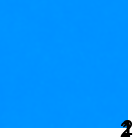

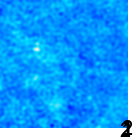

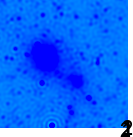

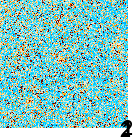

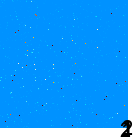

In [8]:
enplot.pshow(SDS_train[10])

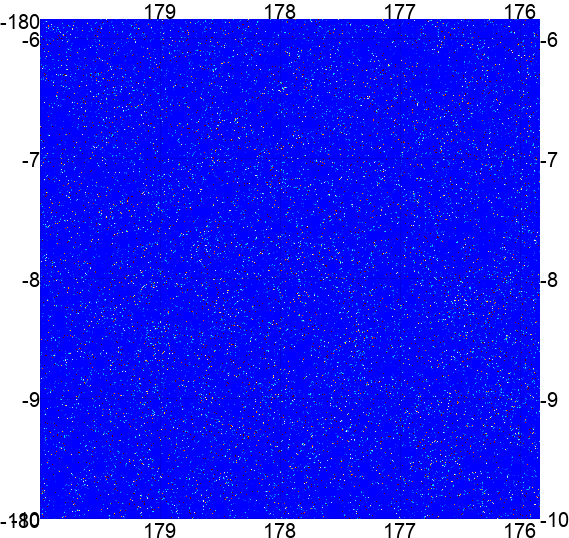

In [9]:
enplot.pshow(input_map[-1,:500,:500])

In [10]:
output_path("sehgal_validation141020")

'/home/dwhan89/workspace/cosmikyu/data/sehgal/sehgal_validation141020'

In [11]:
'''
input_dirv2 = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/rotated_lmax10000_20mjycutsv2"
def input_pathv2(rot_angle1, rot_angle2, compt_idx, dtype):
    freq_idx = "" if compt_idx == "kappa" else "148_"
    file_name = "%s%s_%s_%s_%s_000.fits" %(freq_idx, compt_idx, dtype, "%0.3d"%rot_angle1, "%0.3d"%rot_angle2)
    return os.path.join(input_dirv2, file_name)

def get_input_mapv2(rot_angle1, rot_angle2, nshape, nwcs, compts=compts):
    ishape = nshape[-2:]
    ret = enmap.zeros(nshape, nwcs)
    for i, compt_idx in enumerate(compts):
        dtype = "enmap" if compt_idx == "rad_pts" else "alm"
        input_file = input_pathv2(rot_angle1, rot_angle2, compt_idx, dtype)
        print("loading", input_file)
        if dtype == "alm":
            alm = np.complex128(hp.read_alm(input_file, hdu=(1)))
            ret[i,...] = curvedsky.alm2map(alm, enmap.zeros(ishape, nwcs))
            del alm
        else:
            ret[i,...] = enmap.read_fits(input_file)
    return ret

testv2 = get_input_mapv2(15,20, nshape, nwcs)

idx = -2
alm1 = curvedsky.map2alm(test[idx], lmax=10000)
alm2 = curvedsky.map2alm(testv2[idx], lmax=10000)


cl1 = hp.alm2cl(alm1)
cl2 = hp.alm2cl(alm2)
clx = hp.alm2cl(alm1, alm2)
l = np.arange(len(cl1))
plt.plot(cl1*l**2)
plt.plot(cl2*l**2)
plt.plot(clx*l**2)
plt.yscale("log")
plt.show()

rho = clx/np.sqrt(cl1*cl2)

plt.plot(rho)
'''

'\ninput_dirv2 = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/rotated_lmax10000_20mjycutsv2"\ndef input_pathv2(rot_angle1, rot_angle2, compt_idx, dtype):\n    freq_idx = "" if compt_idx == "kappa" else "148_"\n    file_name = "%s%s_%s_%s_%s_000.fits" %(freq_idx, compt_idx, dtype, "%0.3d"%rot_angle1, "%0.3d"%rot_angle2)\n    return os.path.join(input_dirv2, file_name)\n\ndef get_input_mapv2(rot_angle1, rot_angle2, nshape, nwcs, compts=compts):\n    ishape = nshape[-2:]\n    ret = enmap.zeros(nshape, nwcs)\n    for i, compt_idx in enumerate(compts):\n        dtype = "enmap" if compt_idx == "rad_pts" else "alm"\n        input_file = input_pathv2(rot_angle1, rot_angle2, compt_idx, dtype)\n        print("loading", input_file)\n        if dtype == "alm":\n            alm = np.complex128(hp.read_alm(input_file, hdu=(1)))\n            ret[i,...] = curvedsky.alm2map(alm, enmap.zeros(ishape, nwcs))\n            del alm\n        else:\n            ret[i,...] = enma